# Stats 201B - Homework 3

## Peter Racioppo (103953689)

## Problem 1

In [135]:
import numpy as np
import pandas as pd
from scipy import special
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [136]:
# Load the data
ncog = pd.read_csv("ncog.txt", delimiter = " ")
ncog.sort_values(["arm","t"], inplace = True)
ncog.reset_index(drop = True, inplace = True)
# ncog.head()

In [137]:
# Rename and define new variables:

# Convert from days to months:
ncog["months_study"] = (ncog.t*(12/365)).astype("int") + 1

ncogA_i = ncog.loc[ncog.arm == "A"]
ncogB_i = ncog.loc[ncog.arm == "B"]

ncogA_i = ncogA_i.groupby("months_study").agg({"t": "count", "d": "sum"}
).rename(columns={"t": "n_i", "d": "y"})

ncogB_i = ncogB_i.groupby("months_study").agg({"t": "count", "d": "sum"}
).rename(columns={"t": "n_i", "d": "y"})

ncogA_i["l"] = ncogA_i.n_i - ncogA_i.y
ncogB_i["l"] = ncogB_i.n_i - ncogB_i.y

# ncogA_i.tail()

In [138]:
## Fill in missing months with zeros.
def fill_data(data):
    D = np.zeros((data.index.max(), 4), dtype="int")

    n = data.n_i.sum()
    y = data.y.values
    l = data.l.values

    month_i = 0
    i = 0
    while i < data.shape[0]:
        month = data.index[i]
        while month != month_i + 1:
            month_i = month_i + 1
            D[month_i - 1, :] = [month_i, n, 0, 0]
        y_i = y[i]
        l_i = l[i]
        month_i = month
        
        D[month - 1, :] = (month, n, y_i, l_i)
        
        n = n - (y_i + l_i)
        i = i + 1
    
    return pd.DataFrame(D, columns=["Month", "n", "y", "l"])

In [139]:
ncog_monthsA = fill_data(ncogA_i)
ncog_monthsB = fill_data(ncogB_i)
# ncog_months_a.tail()

In [140]:
# n = number at risk
# y = number of deaths
n_a = np.array(ncog_monthsA[["n"]])
y_a = np.array(ncog_monthsA[["y"]])
n_b = np.array(ncog_monthsB[["n"]])[0:47]
y_b = np.array(ncog_monthsB[["y"]])[0:47]
n_d = y_a + y_b
n = n_a + n_b
n_s = n - n_d
h_a = np.array(y_a/n_a)

In [141]:
k = np.arange(47)
knot = 12
km_t = k-knot
km = [0 if i > 0 else i for i in km_t]
X = np.transpose([np.ones(47),k,np.power(km,2),np.power(km,3)])
print(np.shape(X))

(47, 4)


In [31]:
# # An attempt using linear regression:

# lambd = np.log(h_a/(1-h_a))
# # print(lambd)
# from numpy import inf
# lambd[lambd == -inf] = 0
# ind = np.where(lambd != 0)[0]
# lambd2 = lambd[ind]
# X2 = X[ind,:]

# from sklearn import linear_model
# # Create linear regression object
# regr = linear_model.LinearRegression(fit_intercept=False)
# # Train the model using the training sets
# regr.fit(X2,lambd2)
# inte, alpha = regr.intercept_, regr.coef_
# h_hat = 1/(1 + np.exp(-np.matmul(X2,alpha.T)))

In [142]:
k2 = np.arange(47*5)/5
knot = 12
km_t2 = k2-knot
km2 = [0 if i > 0 else i for i in km_t2]
X2 = np.transpose([np.ones(47*5),k2,np.power(km2,2),np.power(km2,3)])
print(np.shape(X2))

(235, 4)


In [143]:
import warnings
warnings.filterwarnings("ignore")

In [144]:
from sklearn.linear_model import LogisticRegression
clf_a = LogisticRegression(random_state=0).fit(X, y_a)
clf_b = LogisticRegression(random_state=0).fit(X, y_b)

d_a_hat = clf_a.predict_proba(X2)
d_b_hat = clf_b.predict_proba(X2)
# alpha = clf.coef_
# hk = 1/(1+np.exp(-np.sum(np.matmul(X,alpha.T),1)))

c_a = np.arange(np.shape(d_a_hat)[1])+1
c_b = np.arange(np.shape(d_b_hat)[1])+1
# print(np.shape(c*d_hat))
t_a = np.sum(c_a*d_a_hat,1)
t_b = np.sum(c_b*d_b_hat,1)

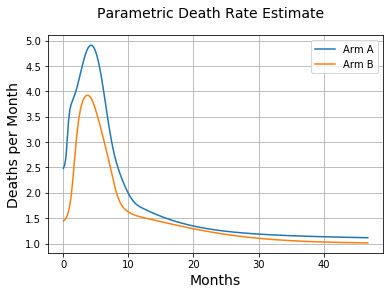

In [147]:
plt.plot(k2,t_a,label="Arm A")
plt.plot(k2,t_b,label="Arm B")
plt.suptitle('Parametric Death Rate Estimate', fontsize=14)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Deaths per Month', fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [305]:
# # Y = [y_a[:,-1],n_a[1:]-y_a[:,-1]]
# Y = np.concatenate((y_a,n_a),1)

## Problem 2

In [21]:
E_a = n_a*n_d/n
V_a = n_a*n_b*n_d*n_s/((n**2)*(n-1))

print(E_a[0:6])
print(E_a[6:13])

[[0.53125   ]
 [1.57894737]
 [3.13043478]
 [3.45882353]
 [6.66666667]
 [5.41538462]]
[[1.41509434]
 [1.46938776]
 [1.36956522]
 [1.3255814 ]
 [0.41025641]
 [0.40540541]
 [0.        ]]


## Problem 3

### The hypergeometric distribution gives the probability of k random draws from a finite set, without replacement. In this case, in a given month, we are randomly "drawing" y deaths from n people at risk. We draw without replacement since the set of people at risk in a particular month decreases by the number who died in the previous month. In addition, we have to account for the fact that a given patient may be in set A or set B.

## Problem 4

(2, 40)
(2, 40)


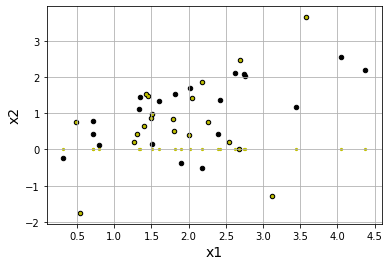

In [586]:
# Bivariate normal data
mu1 = 2
mu2 = 1
means = [mu1, mu2]
cov = [[1, 0.5], [0.5, 1]]
n = 40
data = np.random.multivariate_normal(means,cov,n).T
print(np.shape(data))
data0 = data[0,:]
data1 = data[1,0:20]
data2 = data[1,20:40]*0
# print(np.shape(data1))
# print(np.shape(data2))
data1c = np.concatenate((data1, data2))
datac = np.vstack((data0, data1c))
print(np.shape(datac))

plt.scatter(data[0,:],data[1,:],s=20,color='k')
plt.scatter(datac[0,:],datac[1,:],s=5,color='y')
# plt.suptitle('test title', fontsize=14)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.grid()
plt.show()

In [587]:
def M_step(data):

    n = np.shape(data)[1]
    
    x1 = data[0,:]
    x2 = data[1,:]

#     print(x1)
    
    mu1h = np.sum(x1)/n
    mu2h = np.sum(x2)/n

    sig1h = np.sqrt(np.sum((x1 - mu1h)**2)/n)
    sig2h = np.sqrt(np.sum((x2 - mu2h)**2)/n)

    rhoh = np.sum((x1 - mu1h)*(x2 - mu2h)/40)/(sig1h*sig2h)
    
    theta = [mu1h, mu2h, sig1h, sig2h, rhoh]
    
    return theta

In [588]:
x1 = datac[0,:]
x2 = datac[1,:]
theta = M_step(datac)
x2 = E_step(x1,theta)

In [589]:
def E_step(x1,theta):
    mu1 = theta[0]
    mu2 = theta[1]
    sig1 = theta[2]
    sig2 = theta[3]
    rho = theta[4]
    x2 = mu2 + rho*(sig2/sig1)*(x1-mu1)
    return x2

In [590]:
def EM(data,it):
    x1 = data[0,:]
    x1a = data[0,0:20]
    x1b = data[0,20:40]
    x2a = data[1,0:20]
    for i in np.arange(it):
        theta = M_step(data)
        x2b = E_step(x1b,theta)
        x2 = np.concatenate((x2a, x2b))
        data = np.vstack((x1,x2))
    
    return(data)

In [591]:
# def EM(data,it):
#     x1 = data[0,:]
#     for i in np.arange(it):
#         theta = M_step(data)
#         x2 = E_step(x1,theta)
#         data = np.vstack((x1,x2))
    
#     return(data)

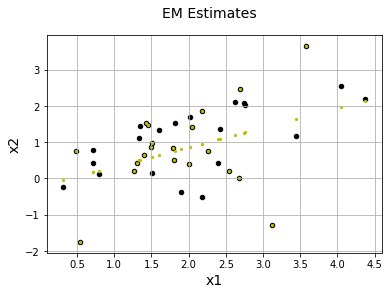

In [593]:
dataf = EM(datac,20)

plt.scatter(data[0,:],data[1,:],s=20,color='k')
plt.scatter(dataf[0,:],dataf[1,:],s=5,color='y')
plt.suptitle('EM Estimates', fontsize=14)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.grid()
plt.show()

## Problem 5

### Part 1

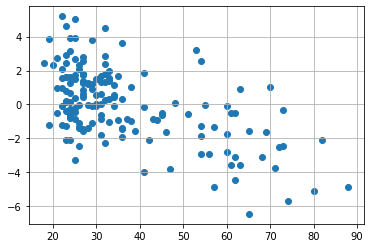

In [690]:
# Load the data
kid = pd.read_csv("kidney.txt", delimiter = " ")
x = np.array(kid.age)
y = np.array(kid.tot)
plt.scatter(x,y)
plt.grid()
plt.show()

In [601]:
# Compute jacknife standard error of correlation.
def samp_corr(x,y):
    n = np.shape(x)[0]
    xb = np.sum(x)/n
    yb = np.sum(y)/n

    num = np.sum((x-xb)*(y-yb))
    denom1 = np.sum((x-xb)**2)
    denom2 = np.sum((y-yb)**2)
    denom = np.sqrt(denom1*denom2)
    s = num/denom
    return(s)

# Remove ith element of vector:
def quitar(x,i):
    x2 = x
    z = np.delete(x2,[i])
    return(z)

In [602]:
def jacknife(x,y):
    n = np.shape(x)[0]
    sumi = 0

    theta_sum = 0
    for i in np.arange(n):
        x_i = quitar(x,i)
        y_i = quitar(y,i)
        theta_i = samp_corr(x_i,y_i)
        theta_sum = theta_sum + theta_i
    theta_b = theta_sum/n

    theta_m = np.zeros(n)
    for i in np.arange(n):
        x_i = quitar(x,i)
        y_i = quitar(y,i)
        theta_i = samp_corr(x_i,y_i)
        theta_m[i] = theta_i - theta_b
        sumi = sumi + theta_m[i]**2

    se_jack = np.sqrt(((n-1)/n)*sumi)
    return [se_jack, theta_m]

se_jack, theta_m = jacknife(x,y)
print("Standard Error =", se_jack)

Standard Error = 0.0582285885521276


### Part 2

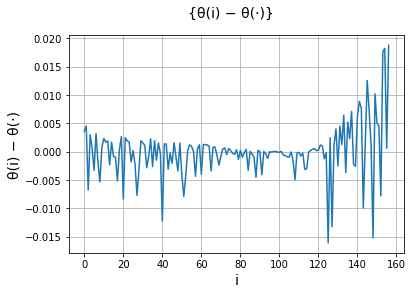

In [606]:
n = np.shape(x)[0]
plt.plot(np.arange(n),theta_m)
plt.suptitle('{θ(i) − θ(·)}', fontsize=14)
plt.xlabel('i', fontsize=14)
plt.ylabel('θ(i) − θ(·)', fontsize=14)
plt.grid()
plt.show()

#### Higher indices appear to make the greater contribution.

### Part 3

In [676]:
# Algorithm 10.1 A Python program for the nonparametric bootstrap.
def Boot(x,y,B):
    # x is data vector or matrix (with each row a case)
    # B is number of bootstrap replications

    n = np.shape(x)[0]
    fmat = np.zeros(B)
    for b in np.arange(B):
        i = np.random.choice(np.arange(n), size = n, replace=True)
        x_samp = x[i]
        y_samp = y[i]
        fmat[b] = samp_corr(x_samp,y_samp)
    
    return fmat

In [697]:
B = 1000
s = Boot(x,y,B)
# sb = mean(s)
# np.sqrt(np.sum((s-sb)**2)/(n-1))
boot_std = np.std(s)
print("bootstrap standard error =", boot_std)

bootstrap standard error = 0.05956514115061613


## Problem 6

### One should generate a large number of bootstrap samples of beta, by sampling the rows of X and y with replacement and then calculating the least-squares estimate. The sample standard deviation of each column of the sampled beta values can then be easily computed.

### An implementation for the two-dimensional case is included below:

[0.98216753 0.907857  ]


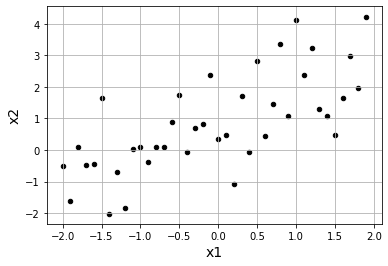

In [95]:
# Generate data:
n = 40
x = np.arange(-20,20)/10
x1 = np.ones(n)
X = np.vstack((x1,x)).T
beta = np.random.uniform(-1, 1, 2)
print(beta)
eps = np.random.normal(0,1,n)
y = np.matmul(X,beta) + eps

plt.scatter(x,y,s=20,color='k')
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.grid()
plt.show()

In [97]:
from numpy import linalg
# Least squares estimate:
def f_LS(X,y):
    # beta_hat = S^-1 * X.T * y, S = X.T * X
    S = np.matmul(X.T,X)
    S_inv = np.linalg.inv(S)
    beta_hat = np.matmul(S_inv,np.matmul(X.T,y))
    return(beta_hat)

beta_hat = f_LS(X,y)
print(beta_hat)

[0.90910993 0.92146686]


In [119]:
# Algorithm 10.1 A Python program for the nonparametric bootstrap.
def Boot(X,y,B):
    # X is data vector or matrix (with each row a case)
    # B is number of bootstrap replications

    n = np.shape(X)[0]
    m = np.shape(X)[1]
    fmat = np.zeros((m,B))
    for b in np.arange(B):
        i = np.random.choice(np.arange(n), size = n, replace=True)
        X_samp = X[i,:]
        y_samp = y[i]
        fmat[:,b] = f_LS(X_samp,y_samp)

    return(fmat.T)

In [128]:
B = 1000
beta = Boot(X,y,B)
# print(beta)
boot_std = [np.std(beta[:,0]), np.std(beta[:,1])]
print("bootstrap standard error =", boot_std)

bootstrap standard error = [0.17444749460351924, 0.155280232345278]


## Problem 8

In [101]:
# Generate data:
nx = 47
ny = 25
x = np.random.normal(0,1,nx)
y = np.random.normal(0,1,ny)

In [102]:
# Computes difference of sample means:
def f_theta_hat(x,y):
    return (np.mean(y) - np.mean(x))

# Computes sample standard error:
def f_se_hat(x,y):
    nx = np.shape(x)[0]
    ny = np.shape(y)[0]
    xb = np.mean(x)
    yb = np.mean(y)
    se_hat = np.sqrt((1/nx + 1/ny) * (sum((x-xb)**2) + sum((y-yb)**2)) / (nx + ny - 2))
    return(se_hat)

In [103]:
# Algorithm 10.1 A Python program for the nonparametric bootstrap.
def Boot(x,y,B):
    # x is data vector or matrix (with each row a case)
    # B is number of bootstrap replications

    nx = np.shape(x)[0]
    ny = np.shape(y)[0]
    theta_hat = np.zeros(B)
    se_hat = np.zeros(B)
    for b in np.arange(B):
        i = np.random.choice(np.arange(nx), size = nx, replace=True)
        j = np.random.choice(np.arange(ny), size = ny, replace=True)
        x_samp = x[i]
        y_samp = y[j]
        theta_hat[b] = f_theta_hat(x_samp,y_samp)
        se_hat[b] = f_se_hat(x_samp,y_samp)

    return(theta_hat, se_hat)

def f_bootstrap_t(theta_hat_star, theta_hat, se_hat_star):
    t_star = (theta_hat_star - theta_hat)/se_hat_star
    return t_star

In [104]:
B = 2000
theta_hat = f_theta_hat(x,y)
[theta_hat_star, se_hat_star] = Boot(x,y,B)

In [105]:
t_star = f_bootstrap_t(theta_hat_star, theta_hat, se_hat_star)

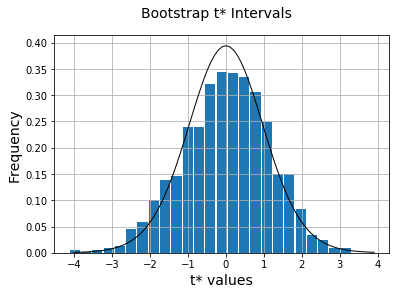

t*_0.025 = -2.321743000627957
t*_0.975 = 2.0866348840062017


In [132]:
from scipy.stats import t
x_ax = np.arange(-40,40)/10

plt.hist(t_star,bins = 25, density = True,histtype="bar",rwidth=0.9)
plt.plot(x_ax, t.pdf(x_ax,df=21),'k-',lw=1,label='t pdf')
plt.suptitle('Bootstrap t* Intervals', fontsize=14)
plt.xlabel('t* values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid()
plt.show()

p_l = np.percentile(t_star, 2.5)
p_h = np.percentile(t_star, 97.5)

print("t*_0.025 =", p_l)
print("t*_0.975 =", p_h)

### How reasonable (11.54) is depends entirely on the means and standard deviations of the normal distributions from which we sample. Since these values aren't provided, I can't comment on the accuracy of the result in the textbook.

### However, note that the percentile values for a standard t_21 distribution are (-2.08, 2.08), which are not far from our values.